In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import time
from PIL import Image
import csv
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [5]:
import random
random.seed(10)

In [6]:
%cd '/content/drive/My Drive/Colab Notebooks/Deep learning/LLaVa_food_grade_project'
%ls
path = os.getcwd()
print('path: ' + path)
output_path = path + '/Output'
ModelPath = path + '/Models'
data_path = path + '/Data'

/content/drive/My Drive/Colab Notebooks/Deep learning/LLaVa_food_grade_project
 Chat_GPT_rating_accuracy.ipynb   GPT2_prediction.ipynb   Output/
 CNN_rating_prediction.ipynb      LLaVa_Inference.ipynb   Prediction_with_CLIP.ipynb
 Data/                            Models/                'Score comparision.ipynb'
path: /content/drive/My Drive/Colab Notebooks/Deep learning/LLaVa_food_grade_project


In [7]:
# Paths
model_path = ModelPath + '/cnn_rating_model'  # Model saving folder

# Create directories if they don't exist
os.makedirs(output_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

In [ ]:
df = pd.read_csv(DataPath+'/reviews.csv')
df_of_tastes = df[df['rating_category'] == 'taste'].copy()
df_of_tastes.reset_index(drop=True, inplace=True)
print(df_of_tastes.head(5).to_string())

                     business_name   author_name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      text                                        photo  rating rating_category
0  Haci'nin Yeri - Yigit Lokantasi   Gulsum Akar  We went to Marmaris with my wife for a holiday. We chose this restaurant as a place for dinner based on the reviews and because we wanted juicy food. 

In [ ]:
# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 50

In [8]:
# Checkpoint path for fail-safe
checkpoint_path = os.path.join(model_path, 'CNN_checkpoint.pth')
train_log_path = os.path.join(output_path, 'CNN_train_log.csv')
test_log_path = os.path.join(output_path, 'CNN_test_log.csv')
predictions_csv = os.path.join(output_path, 'CNN_pred.csv')

In [ ]:
# Dataset and DataLoader
train_df, test_df = train_test_split(df_of_tastes, test_size=0.2, random_state=42)

In [ ]:
# Custom Dataset Class for Image Loading and Transformations
class FoodRatingDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(DataPath, self.df.iloc[idx]['photo'])
        image = Image.open(img_path).convert('RGB')
        rating = self.df.iloc[idx]['rating'] - 1  # Ordinal rating (0-4)

        if self.transform:
            image = self.transform(image)

        return image, rating

In [ ]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# DataLoader
train_dataset = FoodRatingDataset(train_df, transform=transform)
test_dataset = FoodRatingDataset(test_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

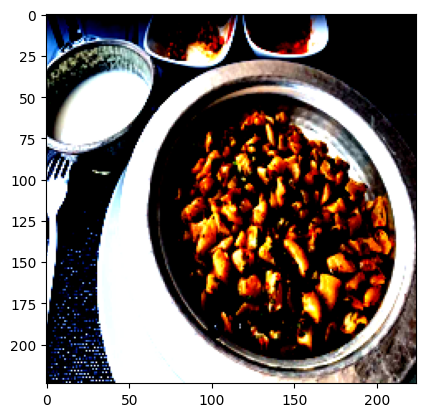

In [ ]:
# Load image from data loader
image, label = next(iter(train_loader))

# Assuming the image is in the format (channels, height, width)
plt.imshow(image[0].permute(1, 2, 0))
plt.show()

In [ ]:
# Ordinal Cross-Entropy Loss
class OrdinalCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(OrdinalCrossEntropyLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, logits, target):
        batch_size = logits.size(0)
        num_classes = logits.size(1) + 1

        # Convert target to ordinal encoding
        target_ord = torch.zeros(batch_size, num_classes - 1).to(logits.device)
        for i in range(num_classes - 1):
            target_ord[:, i] = (target > i).float()

        loss = self.bce_loss(logits, target_ord)
        return loss

In [ ]:
# CNN Model with ordinal outputs (ResNet with MLP head)
class RatingPredictionCNN(nn.Module):
    def __init__(self):
        super(RatingPredictionCNN, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # 4 logits for 1-5 ordinal classification
        )

    def forward(self, x):
        return self.resnet(x)

In [ ]:
# Initialize model, loss, optimizer
model = RatingPredictionCNN()
criterion = OrdinalCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = model.cuda() if torch.cuda.is_available() else model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Checkpoint loading
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1


In [ ]:
# Training loop with CSV logging, MAE metric, early stopping, and fail-safe checkpointing
patience = 5
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    start_time = time.time()

    for images, ratings in train_loader:
        images, ratings = images.cuda(), ratings.cuda() if torch.cuda.is_available() else (images, ratings)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate predictions (convert logits to ratings)
        preds = torch.sum(torch.sigmoid(outputs) > 0.5, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(ratings.cpu().numpy())

    # Calculate overall accuracy and MAE for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_mae = mean_absolute_error(all_labels, all_preds)

    # Log training loss, accuracy, and MAE to CSV
    with open(train_log_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        # Add correct header if it's the first epoch
        if epoch == 0:
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'train_mae'])
        writer.writerow([epoch+1, running_loss / len(train_loader), train_accuracy, train_mae])


    # Print progress with MAE included
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {train_accuracy*100:.2f}%, MAE: {train_mae:.4f}, "
          f"Time: {time.time() - start_time:.2f} seconds")

    # Save checkpoint after each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss
    }, checkpoint_path)

    print(f"Checkpoint saved after epoch {epoch+1}")

    # Early stopping logic
    avg_loss = running_loss / len(train_loader)
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0  # Reset counter if improvement
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1} due to no improvement in loss for {patience} consecutive epochs.")
        break


Epoch 1/50, Loss: 0.5422, Accuracy: 32.58%, MAE: 1.0227, Time: 8.13 seconds
Checkpoint saved after epoch 1
Epoch 2/50, Loss: 0.5045, Accuracy: 28.79%, MAE: 0.9735, Time: 8.32 seconds
Checkpoint saved after epoch 2
Epoch 3/50, Loss: 0.4755, Accuracy: 37.50%, MAE: 0.8864, Time: 7.33 seconds
Checkpoint saved after epoch 3
Epoch 4/50, Loss: 0.4624, Accuracy: 39.02%, MAE: 0.8561, Time: 8.43 seconds
Checkpoint saved after epoch 4
Epoch 5/50, Loss: 0.4452, Accuracy: 43.56%, MAE: 0.8144, Time: 7.12 seconds
Checkpoint saved after epoch 5
Epoch 6/50, Loss: 0.4274, Accuracy: 43.56%, MAE: 0.7879, Time: 8.60 seconds
Checkpoint saved after epoch 6
Epoch 7/50, Loss: 0.4117, Accuracy: 48.11%, MAE: 0.7348, Time: 8.06 seconds
Checkpoint saved after epoch 7
Epoch 8/50, Loss: 0.4086, Accuracy: 50.76%, MAE: 0.7159, Time: 7.72 seconds
Checkpoint saved after epoch 8
Epoch 9/50, Loss: 0.3844, Accuracy: 49.62%, MAE: 0.7083, Time: 8.21 seconds
Checkpoint saved after epoch 9
Epoch 10/50, Loss: 0.3676, Accuracy: 

In [ ]:
# Evaluate and save predictions
model.eval()
all_test_preds = []
all_test_labels = []
indices = []
test_loss = 0.0

with torch.no_grad():
    for idx, (images, ratings) in enumerate(test_loader):
        images, ratings = images.cuda(), ratings.cuda() if torch.cuda.is_available() else (images, ratings)
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, ratings)
        test_loss += loss.item()

        # Predictions (convert logits to ratings)
        preds = torch.sum(torch.sigmoid(outputs) > 0.5, dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(ratings.cpu().numpy())
        indices.extend(test_df.index.values[idx * batch_size:(idx + 1) * batch_size])

# Calculate accuracy and MAE
test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_mae = mean_absolute_error(all_test_labels, all_test_preds)

# Print test results
print(f"Test Loss: {test_loss / len(test_loader):.4f}, "
      f"Test Accuracy: {test_accuracy * 100:.2f}%, "
      f"Test MAE: {test_mae:.4f}")

# Save predicted and true ratings to CSV
predictions_csv = os.path.join(output_path, 'CNN_pred.csv')
with open(predictions_csv, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['index', 'true_rating', 'predicted_rating'])
    for idx, (true_rating, predicted_rating) in enumerate(zip(all_test_labels, all_test_preds)):
        writer.writerow([indices[idx], true_rating + 1, predicted_rating + 1])  # Adjust back to 1-5 scale

print(f"Predictions saved to {predictions_csv}")

Test Loss: 0.7680, Test Accuracy: 33.33%, Test MAE: 1.1667
Predictions saved to /content/drive/My Drive/Colab Notebooks/Deep learning/LLaVa_food_grade_project/Output/resnet_pred.csv


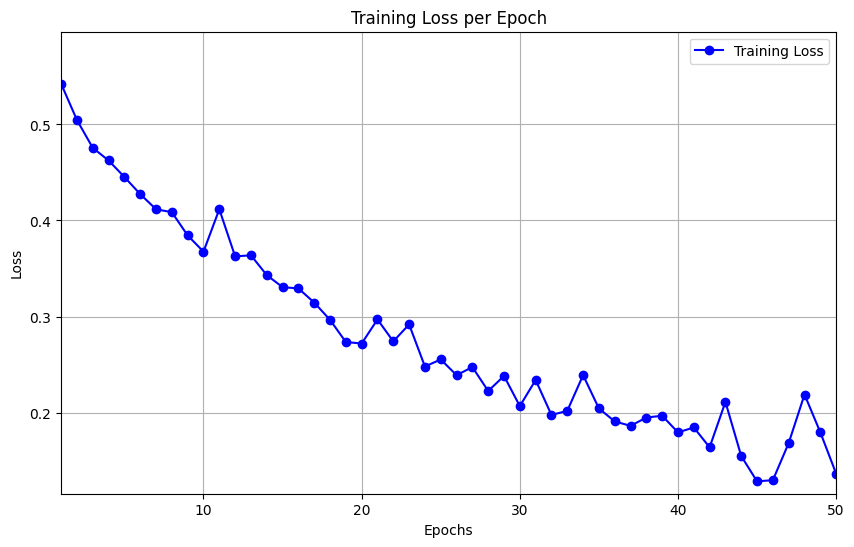

In [9]:

# Load training log and ensure correct data types
train_log = pd.read_csv(train_log_path)
epochs = train_log['epoch'].astype(int)
loss = train_log['train_loss'].astype(float)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label="Training Loss", marker='o', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')

plt.xlim([epochs.min(), epochs.max()])
plt.ylim([loss.min() * 0.9, loss.max() * 1.1])
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_path, 'CNN_Training_Loss.png'))
plt.show()
